<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span><ul class="toc-item"><li><span><a href="#Dataset-Information" data-toc-modified-id="Dataset-Information-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Dataset Information</a></span></li><li><span><a href="#Clean-Target-Variable" data-toc-modified-id="Clean-Target-Variable-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Clean Target Variable</a></span></li><li><span><a href="#Clean-Independent-Variables" data-toc-modified-id="Clean-Independent-Variables-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Clean Independent Variables</a></span></li><li><span><a href="#Feature-Visualizations" data-toc-modified-id="Feature-Visualizations-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Feature Visualizations</a></span></li></ul></li><li><span><a href="#Feature-Engineering" data-toc-modified-id="Feature-Engineering-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Feature Engineering</a></span></li><li><span><a href="#Modeling" data-toc-modified-id="Modeling-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Modeling</a></span><ul class="toc-item"><li><span><a href="#Determine-Best-Model" data-toc-modified-id="Determine-Best-Model-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Determine Best Model</a></span></li><li><span><a href="#Evaluating-Best-Model" data-toc-modified-id="Evaluating-Best-Model-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Evaluating Best Model</a></span></li></ul></li><li><span><a href="#External-Features" data-toc-modified-id="External-Features-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>External Features</a></span></li></ul></div>

# Introduction

- Load the houseprices data from Thinkful's database.
- Do data cleaning, exploratory data analysis, and feature engineering. You can use your previous work in this module. But make sure that your work is satisfactory.
- Now, split your data into train and test sets where 20% of the data resides in the test set.
- Build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!
- Evaluate your best model on the test set.
- So far, you have only used the features in the dataset. However, house prices can be affected by many factors like economic activity and the interest rates at the time they are sold. So, try to find some useful factors that are not included in the dataset. Integrate these factors into your model and assess the prediction performance of your model. Discuss the implications of adding these external variables into your model.


# Imports

In [3]:
from sqlalchemy import create_engine

from statsmodels.tsa.stattools import acf
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from scipy.stats import bartlett
from scipy.stats import levene
from scipy.stats import boxcox

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, RidgeCV, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, GridSearchCV


%matplotlib inline

# Options for pandas
pd.options.display.max_columns = 150
pd.options.display.max_rows = 150

In [161]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
housing_df = pd.read_sql_query('select * from houseprices', con=engine)

engine.dispose()

In [166]:
housing_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


# EDA

## Dataset Information

In [8]:
housing_df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,condition1,condition2,bldgtype,housestyle,overallqual,overallcond,yearbuilt,yearremodadd,roofstyle,roofmatl,exterior1st,exterior2nd,masvnrtype,masvnrarea,exterqual,extercond,foundation,bsmtqual,bsmtcond,bsmtexposure,bsmtfintype1,bsmtfinsf1,bsmtfintype2,bsmtfinsf2,bsmtunfsf,totalbsmtsf,heating,heatingqc,centralair,electrical,firstflrsf,secondflrsf,lowqualfinsf,grlivarea,bsmtfullbath,bsmthalfbath,fullbath,halfbath,bedroomabvgr,kitchenabvgr,kitchenqual,totrmsabvgrd,functional,fireplaces,fireplacequ,garagetype,garageyrblt,garagefinish,garagecars,garagearea,garagequal,garagecond,paveddrive,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,None,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,None,None,None,0,12,2008,WD,Normal,250000


In [9]:
categorical_features = 0
int_feature = 0
for col in housing_df.columns:
    if housing_df[col].dtype == 'O':
        categorical_features += 1
    else:
        int_feature += 1
print('Total columns:', len(housing_df.columns))
print('Numerical columns:', int_feature)
print('Categorical columns:', categorical_features)

Total columns: 81
Numerical columns: 38
Categorical columns: 43


## Clean Target Variable

Before exploring possible independent variable, it's important to clean the target variable beforehand. The reason is because cleaning the target variable may change the relationship between independent variables. 

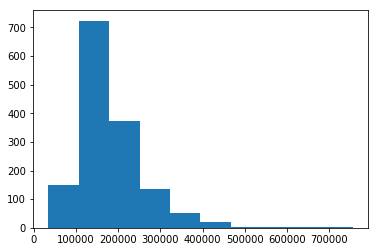

In [10]:
plt.hist(housing_df.saleprice)
plt.show()

The sale price distribution is postively skewed. There are a few outliers that could impact the modeling process. To prevent this we will eliminate observations with sale prices greater than $400,000

In [105]:
len(housing_df[housing_df['saleprice'] > 400000])
print('Drop {} rows with saleprice greater than $400,000'.format(
    len(housing_df[housing_df['saleprice'] > 400000])))
housing_df = housing_df[housing_df['saleprice'] < 400000]

Drop 0 rows with saleprice greater than $400,000


## Clean Independent Variables

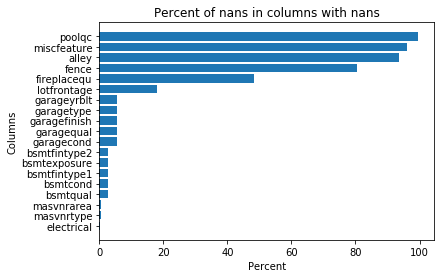

In [12]:
# see percent of nan values within each column
nan_col = housing_df.isnull().sum()/ len(housing_df)*100
nan_col = nan_col.drop(nan_col[nan_col == 0].index).sort_values(ascending=True)
plt.barh(nan_col.keys(),nan_col.values)
plt.title('Percent of nans in columns with nans')
plt.ylabel('Columns')
plt.xlabel('Percent')
plt.show()

Categorical columns with nans can be just filled with the string "None". This is only the case if the nan values represents an absence of that feature within the house (e.g. Nan value in fence column = No fence). 

The nans within numeric columns such as garageyrblt (garage year built) and masvnrarea (Masonry veneer area in square feet), can be replaced with zeros since nans within those columns are likely to also represent an absence of those features. 

Looking at a great [notebook](https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) created by Serigne, I used his idea of using mean imputation for the lot frontage column (Linear feet of street connected to property) ordered by neighborhood. This makes sense since houses within the same neighborhood are likely to have the same lot frontage. 

In [13]:
fill_none_col = ['poolqc', 'miscfeature', 'alley', 'fence', 'fireplacequ', 'garagetype', 
                 'garagefinish', 'garagequal', 'garagecond', 'bsmtqual', 'bsmtcond', 'bsmtexposure',
                 'bsmtfintype1', 'bsmtfintype2', 'masvnrtype', 'electrical']
for col in fill_none_col:
    housing_df[col] = housing_df[col].fillna('None')

    
fill_zero_col = ['garageyrblt', 'masvnrarea']
for col in fill_zero_col:
    housing_df[col] = housing_df[col].fillna(0)
    
housing_df['lotfrontage'] = housing_df.groupby("neighborhood")["lotfrontage"].transform(
    lambda x: x.fillna(x.median()))



In [14]:
# create dummy variables for categorical features
binary_count = 0
for col in housing_df.columns:
    # create dummy variables for binary features
    if (housing_df[col].dtype == 'O') and (len(housing_df[col].value_counts()) == 2):
        binary_col = housing_df[col].value_counts().keys()[0]
        housing_df["is_" + binary_col] = pd.get_dummies(housing_df[col], drop_first=True)
        binary_count += 1
        housing_df.drop(col, axis=1, inplace=True)
    # create dummy variables for other multi-category features
    elif (housing_df[col].dtype == 'O') and (len(housing_df[col].value_counts()) != 2):
        housing_df = pd.concat([housing_df, pd.get_dummies(housing_df[col], prefix=col)], axis=1)
        binary_count += 1
        housing_df.drop(col, axis=1, inplace=True)

## Feature Visualizations

According to [Homeia](https://homeia.com/10-important-features-to-consider-when-buying-a-house/), some of the most important factors for house prices are:

- Location
- Square Feet
- Number of bedrooms/bathrooms
- House quality interior/exterior
- Year Built

Lets see if these specific features or other features have a strong correlation with sale price.

/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:3114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(obj)


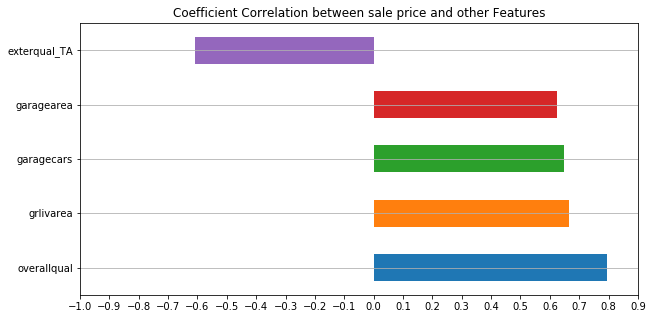

In [15]:
# plot features with coefficient correlations stronger than .5 in regards to sale price.
corr = housing_df.corr()
plot_corr = corr[(corr.saleprice > .6) | (corr.saleprice < -.6)]
plot_corr = plot_corr.saleprice
plot_corr.drop('saleprice', inplace=True)

plt.figure(figsize=(10, 5))
plot_corr.plot(kind='barh', grid=True)
plt.grid(axis='x')
plt.title('Coefficient Correlation between sale price and other Features')
plt.xticks(np.arange(-1, 1, .1))
plt.show()

The overallqual variable (Overall material and finish quality) had the strongest correlation with sale price. In addition, exterqual_TA had a somewhat strong correlation with sale price. These two variables relates to the house quality interior/exterior factor mentioned above in the list. 

The grlivarea (total above ground living area square feet), firstflrsf (first floor square feet) and totalbsmtsf (total basement square feet) all had a somewhat strong correlation with sale price. Since first floor square feet is proportional to above ground square feet, we can just keep above ground living area for the modeling process. 

We can also assume that garagearea and garagecars are proportional to one another so we can exclude one of them within the modeling process.  

Surprisingly location and number of bedrooms/bathrooms were not strongly correlated with sale price. The bedrooms/bathrooms variables will be kept since there may be a transformation that could spark a correlation with sale price. 

# Feature Engineering

In [16]:
# combine related variables from above

housing_df['total_sf'] = housing_df.totalbsmtsf + housing_df.grlivarea + housing_df.garagearea 
+ housing_df.wooddecksf + housing_df.openporchsf + housing_df.poolarea

housing_df['total_fullbaths'] = housing_df.bsmtfullbath + housing_df.fullbath
housing_df['total_halfbaths'] = housing_df.bsmthalfbath + housing_df.halfbath

In [17]:
feature_list = ['overallqual', 'total_sf',
                'total_fullbaths', 'total_halfbaths']

housing_df[feature_list].head()

,overallqual,total_sf,total_fullbaths,total_halfbaths
0,7,3114,3,1
1,6,2984,2,1
2,7,3314,3,1
3,7,3115,2,0
4,8,4179,3,1


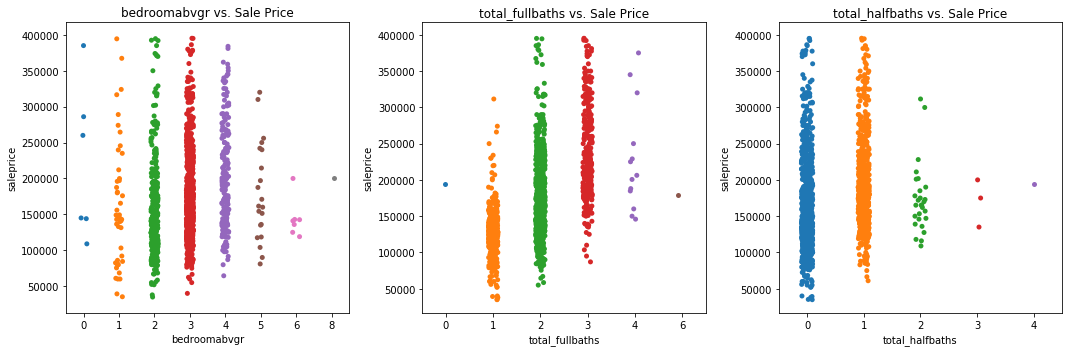

In [18]:
def categorical_plot(df, columns, n_cols=2):
    plt.figure(figsize=(15, 5))
    n_rows = len(columns) / n_cols
    for i in range(1, len(columns)+1):
        plt.subplot(n_rows, n_cols, i)
        sns.stripplot(housing_df[columns[i-1]],
                      housing_df.saleprice, jitter=True)
        plt.title('{} vs. Sale Price'.format(columns[i-1]))
    plt.tight_layout()


plot_col = ['bedroomabvgr', 'total_fullbaths', 'total_halfbaths']
categorical_plot(housing_df, plot_col, 3)

# Modeling

## Determine Best Model

In [54]:
def model_results(model_list, train_x, train_y, test_x, test_y):
    scoring = ['fit_time', 'score_time', 'test_r2', 'train_r2', 'test_neg_mean_absolute_error',
               'train_neg_mean_absolute_error', 'test_neg_mean_squared_error', 'train_neg_mean_squared_error']

    model_dict = []
    for name, model in model_list.items():
        print(name)
        model_stats = {}
        
        alpha_dict = {'alpha': [.01,.1,1,10,100,1000]}
        if name in ['elastic', 'lasso']:
            model = GridSearchCV(model, alpha_dict, cv=3)
            model.fit(train_x, train_y)
            model_stats['best_alpha'] = model.best_params_['alpha']
            model_stats['coef'] = model.best_estimator_.coef_
        else:
            model.fit(train_x,train_y)
            model_stats['coef'] = np.around(model.coef_)
            if name != 'linear':
                model_stats['best_alpha'] = model.alpha_
        
        pred_y = model.predict(test_x)
        
        model_stats['r2'] = model.score(train_x, train_y)
        model_stats['root_MSE'] = np.sqrt(mse(test_y, pred_y))
        model_stats['MAE'] = np.abs(test_y - pred_y).mean()
        model_stats['MAPE'] = (np.abs(test_y - pred_y) / test_y).mean() * 100
        model_stats['model_name'] = name
        
        
        model_dict.append(model_stats)
            
    model_df = pd.DataFrame(model_dict).set_index('model_name')

    return model_df

In [74]:
feature_list = list(housing_df.loc[:,housing_df.columns != 'saleprice'].columns[1:])

train_x, test_x, train_y, test_y = train_test_split(
    housing_df[feature_list], housing_df['saleprice'], test_size=.2)

elastic = ElasticNet()
ridge = RidgeCV(alphas=(.01,1,10,100,1000))
lasso = Lasso()
linear = LinearRegression()
model_list = {'elastic': elastic, 'ridge': ridge, 'lasso': lasso, 'linear': linear}

model_df = model_results(model_list, train_x, train_y, test_x, test_y)

elastic


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

ridge
lasso


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: Conv

linear


/Users/marshallmamiya/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [104]:
lasso_coef = model_df.coef['lasso'] == 0
unique, counts = np.unique(x, return_counts=True)
print('Number of Lasso parameters forced to zero: ',counts[0])

Number of Lasso parameters forced to zero:  107


Using all features within the dataset, the linear model performed the best in regards to R^2 score. The Lasso model had the best MAE, MAPE, and root MSE. Although after multiple iterations, the Ridge model was occasionally the top model in regards to MAE, MAPE, and root MSE. Being that 303 features were used for modeling, I woul argue that Lasso would be the most appropriate model to use (since Lasso forces smaller coefficients to zero). This will reduce processing time and allow  

In [65]:
feature_list = ['overallqual', 'total_sf',
                'total_fullbaths', 'total_halfbaths']

train_x, test_x, train_y, test_y = train_test_split(
    housing_df[feature_list], housing_df['saleprice'], test_size=.2)

model_results(model_list, train_x, train_y, test_x, test_y)

elastic
ridge
lasso
linear


,MAE,MAPE,best_alpha,coef,r2,root_MSE
model_name,,,,,,
elastic,21898.866601,13.460264,0.01,"[22691.13621699353, 27.220839000771768, 13356....",0.755192,30037.951429
ridge,21905.623085,13.468123,0.01,"[22779.0, 27.0, 13535.0, 7484.0]",0.755198,30023.643685
lasso,21905.562364,13.468217,0.01,"[22779.162488793547, 27.042250592001405, 13535...",0.755198,30023.141916
linear,21905.562388,13.468217,NaN,"[22779.0, 27.0, 13535.0, 7485.0]",0.755198,30023.139376


Using only features that had a strong correlation with saleprice, each model performed very similar to one another in regards to all metrics. All regularization models chose the smallest alpha since there was a small amount of features used. The consequence of a small alpha and limited features is large coefficients and possible overfitting. 

## Evaluating Best Model

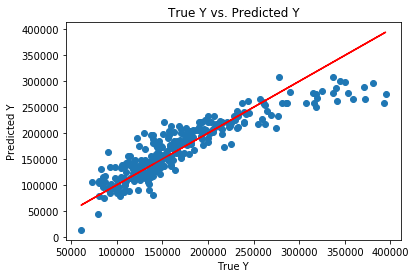

R2:  0.7551808327971636
RMSE: 30023.643685322168
MAE: 21905.62308485304
MAPE: 13.468122864400387
Alpha:  100


In [66]:
lasso = Lasso(alpha=100)
lasso.fit(train_x, train_y)
pred_y = ridge.predict(test_x)

plt.scatter(test_y, pred_y)
plt.plot(test_y, test_y, color='red')
plt.title('True Y vs. Predicted Y')
plt.xlabel('True Y')
plt.ylabel('Predicted Y')
plt.show()

print('R2: ', lasso.score(train_x, train_y))
print('RMSE:', rmse(test_y, pred_y))
print('MAE:', mean_absolute_error(test_y, pred_y))
print('MAPE:', (np.abs(test_y - pred_y) / test_y).mean() *100)
print('Alpha: ', lasso.alpha)

Bartlett test statistic value is 214.592 and p value is 1.37e-48
Levene test statistic value is 180.531 and p value is 5.75e-36


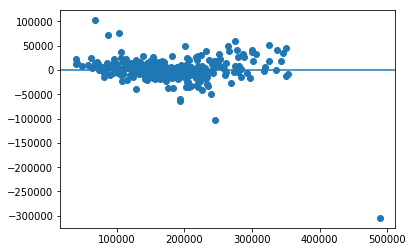

In [64]:
error_term = test_y - pred_y
plt.scatter(pred_y, error_term)
plt.axhline(y=0)


bart_stats = bartlett(pred_y, error_term)
lev_stats = levene(pred_y, error_term)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

The error term is far from being normally distributed. The magnitude of the outlier errors is high for both high and low value predictions. 

# External Features